In [286]:
import dlc_practical_prologue as prologue
import torch
from torch import  nn
from torch.nn import functional as F
import math
from torch import optim
from torch import Tensor
from torch import nn
import matplotlib.pyplot as plt
import math

In [10]:
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)

In [11]:
IMAGE_SIZE = 196
NUM_CLASSES = 10

In [487]:
train_input_1 = train_input[:, 0, :, :]
train_input_2 = train_input[:, 1, :, :]
test_input_1 = test_input[:, 0, :, :]
test_input_2 = test_input[:, 1, :, :]
train_classes_1 = train_classes[:, 0]
train_classes_2 = train_classes[:, 1]
test_classes_1 = test_classes[:, 0]
test_classes_2 = test_classes[:, 1]

VALIDATION_SIZE = 500
indices = [x for x in range(0, train_input_1.size(0))][:VALIDATION_SIZE]
validation_set_input = train_input_1[indices]
validation_set_classes = train_classes_1[indices]

In [13]:
class ShallowFullyConncectedNet(nn.Module):
    def __init__(self, nb_hidden):
        super(ShallowFullyConncectedNet, self).__init__()
        self.fc1 = nn.Linear(IMAGE_SIZE, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, NUM_CLASSES)
        self.name = f"ShallowFullyConncectedNet({nb_hidden})"

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, IMAGE_SIZE)))
        x = self.fc2(x)
        return x

In [14]:
class DeepFullyConncectedNet(nn.Module):
    def __init__(self, nb_layers):
        super(DeepFullyConncectedNet, self).__init__()
        self.layers = nn.ModuleList([])
        self.name = f"DeepFullyConncectedNet({nb_layers})"
        acc = IMAGE_SIZE
        if nb_layers % 2 !=0:
            nb_layers = nb_layers - 1
        for l in range(nb_layers):
            if l < nb_layers/2:
                self.layers.append(nn.Linear(acc, acc*2))
                acc = acc*2
            else:
                self.layers.append(nn.Linear(acc, int(acc/2)))
                acc = int(acc/2)
        self.layers.append(nn.Linear(IMAGE_SIZE, 10))

        

    def forward(self, x):
        acc = IMAGE_SIZE
        for l in range(len(self.layers)-1):
            x = F.relu(self.layers[l](x.view(-1, acc)))
            if l < (len(self.layers)-1)/2:
                acc = acc*2
            else:
                acc = int(acc/2)
        x = self.layers[len(self.layers)-1](x)

       
        return x

In [408]:
class BasicCNN(nn.Module):
    def __init__(self, nb_hidden):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.name = f"BasicCNN({nb_hidden})"

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x.view(-1, 1, 14, 14)), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [445]:
class BasicCNN_bis(nn.Module):
    def __init__(self, dropout = 0):
        super(BasicCNN_bis, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=4)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=4)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=4)
        self.fc1 = nn.Linear(32*5*5, 120)   
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) 
        self.drop = nn.Dropout(dropout)
        self.name = f"BasicCNN_bis(dropout = {dropout})"

    def forward(self, x):
        x = F.relu(self.conv1(x.view(-1, 1, 14, 14)))
        x = self.drop(x)
        x = F.relu(self.conv2(x))
        x = self.drop(x)
        x = F.relu(self.conv3(x))
        x = self.drop(x)
        x = F.relu(self.fc1(x.view(-1, 32*5*5)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [708]:
class BasicCNN_bn(nn.Module):
    def __init__(self, dropout = 0):
        super(BasicCNN_bn, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=4)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 32, kernel_size=4)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5, 120)   
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) 
        self.drop = nn.Dropout(dropout)
        self.name = f"BasicCNN with batch normalization, dropout = {dropout}"

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x.view(-1, 1, 14, 14))))
        print('x ', x.size())
        x = self.drop(x)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = self.drop(x)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = self.drop(x)
        x = F.relu(self.fc1(x.view(-1, 64*5*5)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        print('x ', x.size)
        return x

In [739]:
def double_conv(in_channels, out_channels, dropout):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, 3),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout),
        nn.BatchNorm2d(out_channels)
    )   


class UNet(nn.Module):

    def __init__(self, dropout = 0):
        super(UNet, self).__init__()
                
        self.conv_down1 = double_conv(1, 64, dropout)
        self.conv_down2 = double_conv(64, 128, dropout)
        #self.conv_down3 = double_conv(128, 256, dropout)
        #self.conv_down4 = double_conv(256, 512, dropout)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)     
        
        #self.dconv_up3 = double_conv(256 + 512, 256)
        #self.conv_up2 = double_conv(128 + 256, 128, dropout)
        self.conv_up1 = double_conv(128, 64, dropout)
        
        self.conv_last = nn.Conv2d(64, 2, 1)
        self.fc1 = nn.Linear(2*6*6, 10)   
        self.name = f"UNet, dropout = {dropout}"
        
        
    def forward(self, x):
        conv1 = self.conv_down1(x.view(-1, 1, 14, 14))
        x = self.maxpool(conv1)
        conv2 = self.conv_down2(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        x = self.conv_up1(x)
        x = torch.sigmoid(self.conv_last(x))
        x = self.fc1(x.view(-1, 2*6*6))
        return x

In [756]:
def double_conv(in_channels, out_channels, dropout):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, 3),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout),
        nn.BatchNorm2d(out_channels)
    )   


class UNet2(nn.Module):

    def __init__(self, dropout = 0):
        super(UNet2, self).__init__()
                
        self.conv_down1 = double_conv(1, 64, dropout)
        self.conv_down2 = double_conv(64, 128, dropout)       

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)     
        
        self.conv_up1 = double_conv(128, 64, dropout)
        
        self.fc1 = nn.Linear(64*6*6, 120)   
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)   
        self.name = f"UNet2, dropout = {dropout}"
        
        
    def forward(self, x):
        conv1 = self.conv_down1(x.view(-1, 1, 14, 14))
        x = self.maxpool(conv1)
        conv2 = self.conv_down2(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        x = self.conv_up1(x)
        x = F.relu(self.fc1(x.view(-1, 64*6*6)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
# TODO 
# class ResNetBlock(nn.Module):
#     def __init__(self, nb_channels, kernel_size,
#                  skip_connections = True, batch_normalization = True):
#         super(ResNetBlock, self).__init__()

#         self.conv1 = nn.Conv2d(nb_channels, nb_channels,
#                                kernel_size = kernel_size,
#                                padding = (kernel_size - 1) // 2)

#         self.bn1 = nn.BatchNorm2d(nb_channels)

#         self.conv2 = nn.Conv2d(nb_channels, nb_channels,
#                                kernel_size = kernel_size,
#                                padding = (kernel_size - 1) // 2)

#         self.bn2 = nn.BatchNorm2d(nb_channels)

#         self.skip_connections = skip_connections
#         self.batch_normalization = batch_normalization
        

#     def forward(self, x):
#         y = self.conv1(x)
#         if self.batch_normalization: y = self.bn1(y)
#         y = F.relu(y)
#         y = self.conv2(y)
#         if self.batch_normalization: y = self.bn2(y)
#         if self.skip_connections: y = y + x
#         y = F.relu(y)

#         return y
    

# class ResNet(nn.Module):

#     def __init__(self, nb_residual_blocks, nb_channels,
#                  kernel_size = 3, nb_classes = 10,
#                  skip_connections = True, batch_normalization = True):
#         super(ResNet, self).__init__()

#         self.conv = nn.Conv2d(3, nb_channels,
#                               kernel_size = kernel_size,
#                               padding = (kernel_size - 1) // 2)
#         self.bn = nn.BatchNorm2d(nb_channels)

#         self.resnet_blocks = nn.Sequential(
#             *(ResNetBlock(nb_channels, kernel_size, skip_connections, batch_normalization)
#               for _ in range(nb_residual_blocks))
#         )

#         self.fc = nn.Linear(nb_channels, nb_classes)

#     def forward(self, x):
#         x = F.relu(self.bn(self.conv(x)))
#         x = self.resnet_blocks(x)
#         x = F.avg_pool2d(x, 32).view(x.size(0), -1)
#         x = self.fc(x)
#         return x


In [520]:
optimizer_methods = {
    'SGD': (lambda parameters, eta, momentum: optim.SGD(parameters(), eta, momentum = momentum)),
    'Adam': (lambda parameters, eta, momentum: optim.Adam(parameters(), eta))
}

In [655]:
def train_model(model, train_input, train_target, mini_batch_size, eta, criterion = nn.CrossEntropyLoss(), 
                nb_epochs = 25, validation_set_input = None, validation_set_target = None, 
                momentum = 0, optimizer_name = 'SGD'):
    accuracy = []
    accuracy_test = []
    optimizer = optimizer_methods[optimizer_name](model.parameters, eta, momentum)
    for e in range(nb_epochs):
        running_accuracy = 0
        running_accuracy_test = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            _, predicted_classes = output.max(1)
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_accuracy += compute_nb_correct_digit(predicted_classes, b, train_target, mini_batch_size)
            
        running_loss = loss.item()
        with torch.no_grad():
            output = model(validation_set_input)
            loss = criterion(output, validation_set_target)

            running_loss_test = loss.item()
            _, predicted_classes = output.max(1)
            running_accuracy_test += compute_nb_correct_digit(predicted_classes, 0, validation_set_target, VALIDATION_SIZE)
            
        # print loss statistics
        print('[epoch %d] train loss: %.3f, test loss: %.3f' % (e + 1, running_loss, running_loss_test))
              
        # compute accuracy
        accuracy.append(running_accuracy / train_input.size(0))
        accuracy_test.append(running_accuracy_test / VALIDATION_SIZE)
    return accuracy, accuracy_test

In [656]:
def compute_nb_correct_digit(predicted_classes, b, target, mini_batch_size):
    nb_corrects = 0
    for k in range(mini_batch_size):
        if target[b + k] == predicted_classes[k]:
            nb_corrects += 1
    return nb_corrects 

In [657]:
def compute_nb_coorect_project(predicted_classes1, predicted_classes2, b, target, mini_batch_size):
    nb_corrects = 0
    for k in range(mini_batch_size)
        if target[b + k] == (predicted_classes1[k] <= predicted_classes2[k]):
            nb_corrects += 1
    return nb_corrects

In [683]:
def compute_percentage_project_error(model, input1, input2, target, classes1, classes2, mini_batch_size):
    nb_correct_project = 0
    nb_correct_digit = 0
    for b in range(0, input1.size(0), mini_batch_size):
        output1 = model(input1.narrow(0, b, mini_batch_size))
        output2 = model(input2.narrow(0, b, mini_batch_size))
        _, predicted_classes1 = output1.max(1)
        _, predicted_classes2 = output2.max(1)
        
        nb_correct_digit += compute_nb_correct_digit(predicted_classes1, b, classes1, mini_batch_size)
        nb_correct_digit += compute_nb_correct_digit(predicted_classes2, b, classes2, mini_batch_size)
        nb_correct_project += compute_nb_project_errors(predicted_classes1, predicted_classes2, b, target, mini_batch_size)

    return float(nb_correct_project / target.size(0)), float(nb_correct_digit / (classes1.size(0) + classes2.size(0)))

In [675]:
def plot_accuracy(accuracy, epochs, accuracy_test):
    x = [epoch for epoch in range(1, epochs + 1)]
    plt.plot(x, accuracy, color='green', label = 'train accuracy')
    plt.plot(x, accuracy_test, color = 'orange', label = 'validation set accuracy')
    plt.xlabel('Number of epoch')
    plt.ylabel('Digit acuuracy')
    plt.title('Accuracy in function of the number of epochs')
    plt.legend()
    plt.show()

In [685]:
def train_test(model, mini_batch_size, eta, criterion, nb_epochs, momentum = 0, optimizer_name = 'SGD'):
    train = torch.cat((train_input_1, train_input_2), 0)
    target = torch.cat((train_classes_1, train_classes_2), 0)

    accuracy, accuracy_test = train_model(model, train, target, mini_batch_size, eta, criterion, nb_epochs, 
                                          validation_set_input, validation_set_classes, momentum, optimizer_name)
    plot_accuracy(accuracy, nb_epochs, accuracy_test)
    train_acc_project, train_acc_digit = compute_percentage_project_error(model, train_input_1, train_input_2, train_target, train_classes_1, train_classes_2, mini_batch_size) 
    test_acc_project, test_acc_digit = compute_percentage_project_error(model, test_input_1, test_input_2, test_target, test_classes_1, test_classes_2, mini_batch_size) 
    print(f'MODEL: {model.name}, BATCH_SIZE: { mini_batch_size}, CRITERION: {str(criterion)}, EPOCHS: {nb_epochs}, train_accuracy:{train_acc_project}, test_accuracy: {test_acc_project}, train_accuracy_digit:{train_acc_digit}, test_accuracy_digit: {test_acc_digit}')

### Basic CNN optimization:

#### Momentum = 0

[epoch 1] train loss: 2.228, test loss: 2.161
[epoch 2] train loss: 2.300, test loss: 2.302
[epoch 3] train loss: 2.297, test loss: 2.300
[epoch 4] train loss: 2.293, test loss: 2.295
[epoch 5] train loss: 2.295, test loss: 2.298
[epoch 6] train loss: 2.295, test loss: 2.297
[epoch 7] train loss: 2.276, test loss: 2.271
[epoch 8] train loss: 2.299, test loss: 2.303
[epoch 9] train loss: 2.292, test loss: 2.295
[epoch 10] train loss: 2.207, test loss: 2.184
[epoch 11] train loss: 1.783, test loss: 1.685
[epoch 12] train loss: 1.528, test loss: 1.259
[epoch 13] train loss: 1.550, test loss: 1.421
[epoch 14] train loss: 1.418, test loss: 2.185
[epoch 15] train loss: 0.877, test loss: 1.125
[epoch 16] train loss: 0.649, test loss: 0.608
[epoch 17] train loss: 0.477, test loss: 0.459
[epoch 18] train loss: 0.421, test loss: 0.381
[epoch 19] train loss: 0.418, test loss: 0.464
[epoch 20] train loss: 0.245, test loss: 0.420
[epoch 21] train loss: 0.235, test loss: 0.330
[epoch 22] train loss:

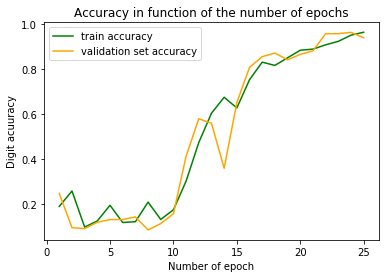

MODEL: BasicCNN_bis(dropout = 0), BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 25, train_error:0.094%, test_error: 0.09%, train_error_digit:0.9465%, test_error_digit: 0.095%


In [670]:
train_test(BasicCNN_bis(), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 25)

In [671]:
train_test(BasicCNN_bis(), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100)

[epoch 1] train loss: 2.306, test loss: 2.298
[epoch 2] train loss: 2.259, test loss: 2.246
[epoch 3] train loss: 1.849, test loss: 1.721
[epoch 4] train loss: 1.266, test loss: 1.120
[epoch 5] train loss: 0.832, test loss: 0.817
[epoch 6] train loss: 0.666, test loss: 0.778
[epoch 7] train loss: 0.483, test loss: 0.453
[epoch 8] train loss: 0.269, test loss: 0.306
[epoch 9] train loss: 0.203, test loss: 0.219
[epoch 10] train loss: 0.242, test loss: 0.181
[epoch 11] train loss: 0.195, test loss: 0.188
[epoch 12] train loss: 0.305, test loss: 0.321
[epoch 13] train loss: 0.103, test loss: 0.134
[epoch 14] train loss: 0.075, test loss: 0.060
[epoch 15] train loss: 0.037, test loss: 0.047
[epoch 16] train loss: 0.011, test loss: 0.039
[epoch 17] train loss: 0.915, test loss: 0.603
[epoch 18] train loss: 0.140, test loss: 0.093
[epoch 19] train loss: 0.098, test loss: 0.068
[epoch 20] train loss: 0.051, test loss: 0.062
[epoch 21] train loss: 0.078, test loss: 0.045
[epoch 22] train loss:

KeyboardInterrupt: 

In [ ]:
train_test(BasicCNN_bis(dropout = 0.1), 100, eta = 1e-1, criterion = nn.CrossEntropyLoss(), nb_epochs = 100)

In [709]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 25)

x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1316dfab0>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1378cbe58>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x136837360>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1378cbdc8>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1378cb3f0>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1378cb1f8>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1316df6c0>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x138ad94c8>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1378cb7e0>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x136837360>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1378cbdc8>
x  torch.S

x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1378cb3f0>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1316df6c0>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1316dfab0>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1378cbdc8>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x136837360>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1378cb1f8>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1378cbcf0>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1378cb3f0>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1316dff78>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x138ad94c8>
x  torch.Size([100, 6, 11, 11])
x  <built-in method size of Tensor object at 0x1378cb7e0>
x  torch.S

KeyboardInterrupt: 

In [ ]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100)

In [ ]:
train_test(BasicCNN_bn(dropout = 0.2), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100)

In [ ]:
train_test(BasicCNN_bn(dropout = 0.5), 100, eta = 0.1, criterion =nn.CrossEntropyLoss(), nb_epochs = 1000)

#### Monentum = 0.9

In [ ]:
train_test(BasicCNN_bis(), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 25, momentum = 0.9)

In [ ]:
train_test(BasicCNN_bis(), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

In [ ]:
train_test(BasicCNN_bis(dropout = 0.1), 100, eta = 1e-1, criterion = nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

In [ ]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 25, momentum = 0.9)

In [ ]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

In [ ]:
train_test(BasicCNN_bn(dropout = 0.2), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

In [ ]:
train_test(BasicCNN_bn(dropout = 0.2), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 1000, momentum = 0.9)

In [ ]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 1000, momentum = 0.9)

#### Adam optimizer

In [ ]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 25, optimizer_name = 'Adam')

In [ ]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, optimizer_name = 'Adam')

In [ ]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 500, optimizer_name = 'Adam')

In [ ]:
train_test(BasicCNN_bn(dropout = 0.2), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 500, optimizer_name = 'Adam')

In [ ]:
train_test(BasicCNN_bis(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, optimizer_name = 'Adam')

In [ ]:
train_test(BasicCNN_bis(dropout = 0.2), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, optimizer_name = 'Adam')

In [ ]:
train_test(BasicCNN_bis(dropout = 0.2), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 500, optimizer_name = 'Adam')

#### Multi margin loss

[epoch 1] train loss: 0.341, test loss: 0.350
[epoch 2] train loss: 0.148, test loss: 0.152
[epoch 3] train loss: 0.255, test loss: 0.174
[epoch 4] train loss: 0.197, test loss: 0.080
[epoch 5] train loss: 0.114, test loss: 0.143
[epoch 6] train loss: 0.138, test loss: 0.066
[epoch 7] train loss: 0.066, test loss: 0.046
[epoch 8] train loss: 0.048, test loss: 0.037
[epoch 9] train loss: 0.050, test loss: 0.044
[epoch 10] train loss: 0.042, test loss: 0.035
[epoch 11] train loss: 0.032, test loss: 0.045
[epoch 12] train loss: 0.040, test loss: 0.027
[epoch 13] train loss: 0.053, test loss: 0.034
[epoch 14] train loss: 0.035, test loss: 0.033
[epoch 15] train loss: 0.021, test loss: 0.036
[epoch 16] train loss: 0.015, test loss: 0.022
[epoch 17] train loss: 0.028, test loss: 0.020
[epoch 18] train loss: 0.018, test loss: 0.019
[epoch 19] train loss: 0.010, test loss: 0.008
[epoch 20] train loss: 0.011, test loss: 0.023
[epoch 21] train loss: 0.008, test loss: 0.007
[epoch 22] train loss:

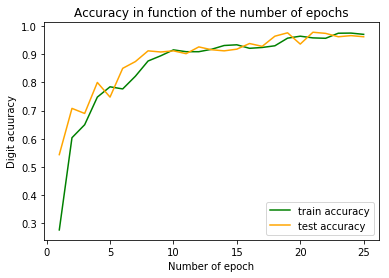

MODEL: BasicCNN_bis(dropout = 0), BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 25, train_error:2.6%, test_error: 11.0%


In [549]:
train_test(BasicCNN_bis(), 100, eta = 1e-1, criterion =nn.MultiMarginLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 0.883, test loss: 0.896
[epoch 2] train loss: 0.864, test loss: 0.875
[epoch 3] train loss: 0.709, test loss: 0.700
[epoch 4] train loss: 0.614, test loss: 0.592
[epoch 5] train loss: 0.474, test loss: 0.403
[epoch 6] train loss: 0.421, test loss: 0.349
[epoch 7] train loss: 0.410, test loss: 0.334
[epoch 8] train loss: 0.394, test loss: 0.304
[epoch 9] train loss: 0.399, test loss: 0.285
[epoch 10] train loss: 0.332, test loss: 0.259
[epoch 11] train loss: 0.337, test loss: 0.237
[epoch 12] train loss: 0.327, test loss: 0.250
[epoch 13] train loss: 0.302, test loss: 0.230
[epoch 14] train loss: 0.299, test loss: 0.171
[epoch 15] train loss: 0.269, test loss: 0.171
[epoch 16] train loss: 0.231, test loss: 0.155
[epoch 17] train loss: 0.212, test loss: 0.149
[epoch 18] train loss: 0.211, test loss: 0.154
[epoch 19] train loss: 0.204, test loss: 0.146
[epoch 20] train loss: 0.196, test loss: 0.149
[epoch 21] train loss: 0.208, test loss: 0.125
[epoch 22] train loss:

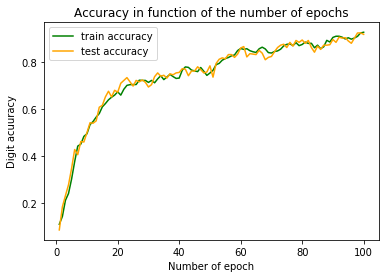

MODEL: BasicCNN_bis(dropout = 0), BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 100, train_error:5.6000000000000005%, test_error: 19.6%


In [551]:
train_test(BasicCNN_bis(), 100, eta = 1e-1, criterion =nn.MultiMarginLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 0.476, test loss: 0.551
[epoch 2] train loss: 0.424, test loss: 0.475
[epoch 3] train loss: 0.319, test loss: 0.478
[epoch 4] train loss: 0.429, test loss: 0.452
[epoch 5] train loss: 0.372, test loss: 0.323
[epoch 6] train loss: 0.236, test loss: 0.205
[epoch 7] train loss: 0.232, test loss: 0.216
[epoch 8] train loss: 0.175, test loss: 0.205
[epoch 9] train loss: 0.158, test loss: 0.145
[epoch 10] train loss: 0.152, test loss: 0.139
[epoch 11] train loss: 0.158, test loss: 0.133
[epoch 12] train loss: 0.129, test loss: 0.111
[epoch 13] train loss: 0.120, test loss: 0.114
[epoch 14] train loss: 0.163, test loss: 0.153
[epoch 15] train loss: 0.087, test loss: 0.094
[epoch 16] train loss: 0.080, test loss: 0.116
[epoch 17] train loss: 0.098, test loss: 0.109
[epoch 18] train loss: 0.101, test loss: 0.099
[epoch 19] train loss: 0.118, test loss: 0.112
[epoch 20] train loss: 0.104, test loss: 0.110
[epoch 21] train loss: 0.171, test loss: 0.098
[epoch 22] train loss:

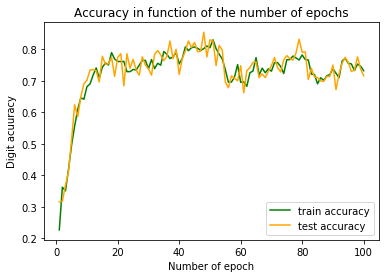

MODEL: BasicCNN_bis(dropout = 0.1), BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 100, train_error:18.099999999999998%, test_error: 21.6%


In [552]:
train_test(BasicCNN_bis(dropout = 0.1), 100, eta = 1e-1, criterion = nn.MultiMarginLoss(), nb_epochs = 100, momentum = 0.9)

x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x131736240>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794ab0>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794e10>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794ab0>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 6

x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794ab0>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794e10>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794ab0>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 6

x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x138db0a20>
x  torch.Size([500, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
[epoch 9] train loss: 0.001, test loss: 0.002
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x131736240>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x138db0a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tenso

x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794e10>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794ab0>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794e10>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 6

x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x138db0a20>
x  torch.Size([500, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
[epoch 18] train loss: 0.000, test loss: 0.001
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x137f01e58>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x138db0a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tens

x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794ab0>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794e10>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 6

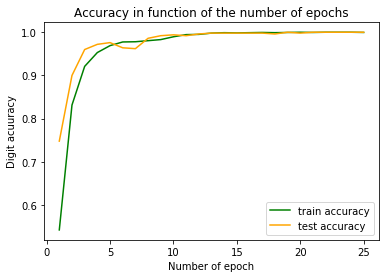

x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b300af8>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1396e4708>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b300750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b3003a8>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b3001f8>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b300318>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b3005a0>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b3003f0>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b300168>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b300af8>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b300750>
x  torch.Size([100, 6

In [610]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.MultiMarginLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 0.086, test loss: 0.059
[epoch 2] train loss: 0.072, test loss: 0.029
[epoch 3] train loss: 0.023, test loss: 0.012
[epoch 4] train loss: 0.017, test loss: 0.009
[epoch 5] train loss: 0.011, test loss: 0.009
[epoch 6] train loss: 0.004, test loss: 0.007
[epoch 7] train loss: 0.001, test loss: 0.004
[epoch 8] train loss: 0.002, test loss: 0.005
[epoch 9] train loss: 0.002, test loss: 0.001
[epoch 10] train loss: 0.001, test loss: 0.002
[epoch 11] train loss: 0.001, test loss: 0.001
[epoch 12] train loss: 0.000, test loss: 0.001
[epoch 13] train loss: 0.000, test loss: 0.001
[epoch 14] train loss: 0.000, test loss: 0.000
[epoch 15] train loss: 0.000, test loss: 0.000
[epoch 16] train loss: 0.000, test loss: 0.000
[epoch 17] train loss: 0.000, test loss: 0.000
[epoch 18] train loss: 0.000, test loss: 0.000
[epoch 19] train loss: 0.000, test loss: 0.000
[epoch 20] train loss: 0.000, test loss: 0.000
[epoch 21] train loss: 0.000, test loss: 0.000
[epoch 22] train loss:

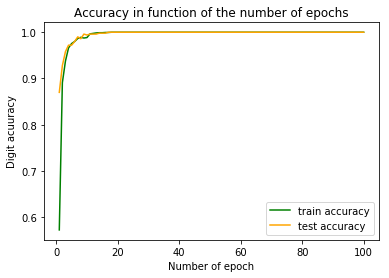

MODEL: BasicCNN with batch normalization, dropout = 0, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 100, train_error:0.0%, test_error: 3.2%


In [554]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.MultiMarginLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 0.176, test loss: 0.131
[epoch 2] train loss: 0.133, test loss: 0.057
[epoch 3] train loss: 0.059, test loss: 0.031
[epoch 4] train loss: 0.039, test loss: 0.027
[epoch 5] train loss: 0.033, test loss: 0.018
[epoch 6] train loss: 0.023, test loss: 0.021
[epoch 7] train loss: 0.020, test loss: 0.019
[epoch 8] train loss: 0.028, test loss: 0.018
[epoch 9] train loss: 0.016, test loss: 0.020
[epoch 10] train loss: 0.023, test loss: 0.015
[epoch 11] train loss: 0.018, test loss: 0.014
[epoch 12] train loss: 0.015, test loss: 0.014
[epoch 13] train loss: 0.009, test loss: 0.011
[epoch 14] train loss: 0.008, test loss: 0.007
[epoch 15] train loss: 0.014, test loss: 0.007
[epoch 16] train loss: 0.005, test loss: 0.004
[epoch 17] train loss: 0.006, test loss: 0.005
[epoch 18] train loss: 0.007, test loss: 0.004
[epoch 19] train loss: 0.006, test loss: 0.004
[epoch 20] train loss: 0.007, test loss: 0.004
[epoch 21] train loss: 0.004, test loss: 0.003
[epoch 22] train loss:

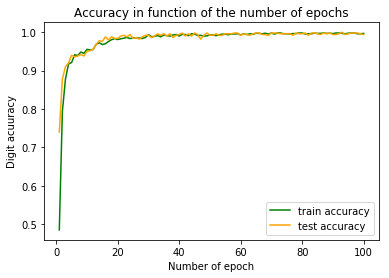

MODEL: BasicCNN with batch normalization, dropout = 0.2, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 100, train_error:0.4%, test_error: 4.1000000000000005%


In [555]:
train_test(BasicCNN_bn(dropout = 0.2), 100, eta = 1e-1, criterion =nn.MultiMarginLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 0.163, test loss: 0.090
[epoch 2] train loss: 0.089, test loss: 0.067
[epoch 3] train loss: 0.069, test loss: 0.033
[epoch 4] train loss: 0.033, test loss: 0.023
[epoch 5] train loss: 0.030, test loss: 0.017
[epoch 6] train loss: 0.043, test loss: 0.014
[epoch 7] train loss: 0.020, test loss: 0.015
[epoch 8] train loss: 0.010, test loss: 0.013
[epoch 9] train loss: 0.019, test loss: 0.015
[epoch 10] train loss: 0.012, test loss: 0.015
[epoch 11] train loss: 0.012, test loss: 0.012
[epoch 12] train loss: 0.008, test loss: 0.011
[epoch 13] train loss: 0.011, test loss: 0.009
[epoch 14] train loss: 0.007, test loss: 0.008
[epoch 15] train loss: 0.004, test loss: 0.008
[epoch 16] train loss: 0.017, test loss: 0.004
[epoch 17] train loss: 0.006, test loss: 0.007
[epoch 18] train loss: 0.015, test loss: 0.006
[epoch 19] train loss: 0.008, test loss: 0.005
[epoch 20] train loss: 0.004, test loss: 0.003
[epoch 21] train loss: 0.006, test loss: 0.004
[epoch 22] train loss:

[epoch 174] train loss: 0.000, test loss: 0.000
[epoch 175] train loss: 0.003, test loss: 0.001
[epoch 176] train loss: 0.002, test loss: 0.000
[epoch 177] train loss: 0.001, test loss: 0.001
[epoch 178] train loss: 0.001, test loss: 0.000
[epoch 179] train loss: 0.000, test loss: 0.001
[epoch 180] train loss: 0.000, test loss: 0.000
[epoch 181] train loss: 0.000, test loss: 0.001
[epoch 182] train loss: 0.000, test loss: 0.000
[epoch 183] train loss: 0.001, test loss: 0.000
[epoch 184] train loss: 0.000, test loss: 0.000
[epoch 185] train loss: 0.000, test loss: 0.002
[epoch 186] train loss: 0.001, test loss: 0.001
[epoch 187] train loss: 0.000, test loss: 0.001
[epoch 188] train loss: 0.000, test loss: 0.001
[epoch 189] train loss: 0.001, test loss: 0.000
[epoch 190] train loss: 0.003, test loss: 0.001
[epoch 191] train loss: 0.003, test loss: 0.000
[epoch 192] train loss: 0.000, test loss: 0.000
[epoch 193] train loss: 0.001, test loss: 0.000
[epoch 194] train loss: 0.000, test loss

[epoch 345] train loss: 0.000, test loss: 0.000
[epoch 346] train loss: 0.000, test loss: 0.000
[epoch 347] train loss: 0.001, test loss: 0.000
[epoch 348] train loss: 0.000, test loss: 0.000
[epoch 349] train loss: 0.000, test loss: 0.000
[epoch 350] train loss: 0.000, test loss: 0.000
[epoch 351] train loss: 0.000, test loss: 0.000
[epoch 352] train loss: 0.000, test loss: 0.000
[epoch 353] train loss: 0.000, test loss: 0.000
[epoch 354] train loss: 0.000, test loss: 0.000
[epoch 355] train loss: 0.002, test loss: 0.000
[epoch 356] train loss: 0.001, test loss: 0.000
[epoch 357] train loss: 0.002, test loss: 0.000
[epoch 358] train loss: 0.000, test loss: 0.001
[epoch 359] train loss: 0.000, test loss: 0.000
[epoch 360] train loss: 0.000, test loss: 0.000
[epoch 361] train loss: 0.000, test loss: 0.000
[epoch 362] train loss: 0.000, test loss: 0.000
[epoch 363] train loss: 0.000, test loss: 0.001
[epoch 364] train loss: 0.000, test loss: 0.000
[epoch 365] train loss: 0.000, test loss

[epoch 516] train loss: 0.000, test loss: 0.000
[epoch 517] train loss: 0.000, test loss: 0.000
[epoch 518] train loss: 0.000, test loss: 0.001
[epoch 519] train loss: 0.003, test loss: 0.001
[epoch 520] train loss: 0.000, test loss: 0.000
[epoch 521] train loss: 0.000, test loss: 0.000
[epoch 522] train loss: 0.000, test loss: 0.000
[epoch 523] train loss: 0.000, test loss: 0.000
[epoch 524] train loss: 0.000, test loss: 0.000
[epoch 525] train loss: 0.000, test loss: 0.000
[epoch 526] train loss: 0.000, test loss: 0.000
[epoch 527] train loss: 0.000, test loss: 0.000
[epoch 528] train loss: 0.001, test loss: 0.000
[epoch 529] train loss: 0.000, test loss: 0.000
[epoch 530] train loss: 0.000, test loss: 0.000
[epoch 531] train loss: 0.000, test loss: 0.000
[epoch 532] train loss: 0.000, test loss: 0.000
[epoch 533] train loss: 0.000, test loss: 0.000
[epoch 534] train loss: 0.000, test loss: 0.000
[epoch 535] train loss: 0.000, test loss: 0.000
[epoch 536] train loss: 0.000, test loss

[epoch 687] train loss: 0.000, test loss: 0.000
[epoch 688] train loss: 0.000, test loss: 0.000
[epoch 689] train loss: 0.000, test loss: 0.000
[epoch 690] train loss: 0.000, test loss: 0.001
[epoch 691] train loss: 0.000, test loss: 0.000
[epoch 692] train loss: 0.000, test loss: 0.000
[epoch 693] train loss: 0.000, test loss: 0.000
[epoch 694] train loss: 0.000, test loss: 0.000
[epoch 695] train loss: 0.000, test loss: 0.000
[epoch 696] train loss: 0.000, test loss: 0.000
[epoch 697] train loss: 0.000, test loss: 0.000
[epoch 698] train loss: 0.000, test loss: 0.000
[epoch 699] train loss: 0.000, test loss: 0.000
[epoch 700] train loss: 0.000, test loss: 0.000
[epoch 701] train loss: 0.000, test loss: 0.000
[epoch 702] train loss: 0.000, test loss: 0.000
[epoch 703] train loss: 0.000, test loss: 0.000
[epoch 704] train loss: 0.000, test loss: 0.000
[epoch 705] train loss: 0.001, test loss: 0.000
[epoch 706] train loss: 0.000, test loss: 0.000
[epoch 707] train loss: 0.000, test loss

[epoch 858] train loss: 0.000, test loss: 0.000
[epoch 859] train loss: 0.000, test loss: 0.000
[epoch 860] train loss: 0.000, test loss: 0.000
[epoch 861] train loss: 0.000, test loss: 0.000
[epoch 862] train loss: 0.000, test loss: 0.000
[epoch 863] train loss: 0.000, test loss: 0.000
[epoch 864] train loss: 0.000, test loss: 0.000
[epoch 865] train loss: 0.000, test loss: 0.000
[epoch 866] train loss: 0.000, test loss: 0.000
[epoch 867] train loss: 0.000, test loss: 0.000
[epoch 868] train loss: 0.000, test loss: 0.000
[epoch 869] train loss: 0.000, test loss: 0.000
[epoch 870] train loss: 0.000, test loss: 0.000
[epoch 871] train loss: 0.000, test loss: 0.000
[epoch 872] train loss: 0.000, test loss: 0.000
[epoch 873] train loss: 0.000, test loss: 0.000
[epoch 874] train loss: 0.000, test loss: 0.000
[epoch 875] train loss: 0.000, test loss: 0.000
[epoch 876] train loss: 0.000, test loss: 0.000
[epoch 877] train loss: 0.000, test loss: 0.000
[epoch 878] train loss: 0.000, test loss

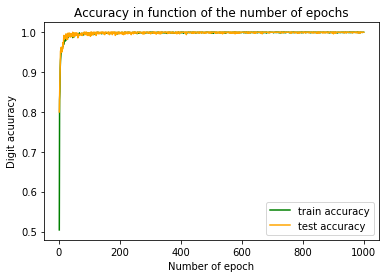

MODEL: BasicCNN with batch normalization, dropout = 0.2, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 1000, train_error:0.1%, test_error: 1.6%


In [556]:
train_test(BasicCNN_bn(dropout = 0.2), 100, eta = 1e-1, criterion =nn.MultiMarginLoss(), nb_epochs = 1000, momentum = 0.9)

[epoch 1] train loss: 0.160, test loss: 0.148
[epoch 2] train loss: 0.061, test loss: 0.028
[epoch 3] train loss: 0.026, test loss: 0.014
[epoch 4] train loss: 0.029, test loss: 0.011
[epoch 5] train loss: 0.012, test loss: 0.008
[epoch 6] train loss: 0.012, test loss: 0.013
[epoch 7] train loss: 0.005, test loss: 0.016
[epoch 8] train loss: 0.006, test loss: 0.007
[epoch 9] train loss: 0.003, test loss: 0.006
[epoch 10] train loss: 0.001, test loss: 0.002
[epoch 11] train loss: 0.000, test loss: 0.002
[epoch 12] train loss: 0.000, test loss: 0.001
[epoch 13] train loss: 0.000, test loss: 0.001
[epoch 14] train loss: 0.000, test loss: 0.001
[epoch 15] train loss: 0.000, test loss: 0.001
[epoch 16] train loss: 0.000, test loss: 0.001
[epoch 17] train loss: 0.000, test loss: 0.001
[epoch 18] train loss: 0.000, test loss: 0.000
[epoch 19] train loss: 0.000, test loss: 0.000
[epoch 20] train loss: 0.000, test loss: 0.000
[epoch 21] train loss: 0.000, test loss: 0.000
[epoch 22] train loss:

[epoch 174] train loss: 0.000, test loss: 0.000
[epoch 175] train loss: 0.000, test loss: 0.000
[epoch 176] train loss: 0.000, test loss: 0.000
[epoch 177] train loss: 0.000, test loss: 0.000
[epoch 178] train loss: 0.000, test loss: 0.000
[epoch 179] train loss: 0.000, test loss: 0.000
[epoch 180] train loss: 0.000, test loss: 0.000
[epoch 181] train loss: 0.000, test loss: 0.000
[epoch 182] train loss: 0.000, test loss: 0.000
[epoch 183] train loss: 0.000, test loss: 0.000
[epoch 184] train loss: 0.000, test loss: 0.000
[epoch 185] train loss: 0.000, test loss: 0.000
[epoch 186] train loss: 0.000, test loss: 0.000
[epoch 187] train loss: 0.000, test loss: 0.000
[epoch 188] train loss: 0.000, test loss: 0.000
[epoch 189] train loss: 0.000, test loss: 0.000
[epoch 190] train loss: 0.000, test loss: 0.000
[epoch 191] train loss: 0.000, test loss: 0.000
[epoch 192] train loss: 0.000, test loss: 0.000
[epoch 193] train loss: 0.000, test loss: 0.000
[epoch 194] train loss: 0.000, test loss

[epoch 345] train loss: 0.000, test loss: 0.000
[epoch 346] train loss: 0.000, test loss: 0.000
[epoch 347] train loss: 0.000, test loss: 0.000
[epoch 348] train loss: 0.000, test loss: 0.000
[epoch 349] train loss: 0.000, test loss: 0.000
[epoch 350] train loss: 0.000, test loss: 0.000
[epoch 351] train loss: 0.000, test loss: 0.000
[epoch 352] train loss: 0.000, test loss: 0.000
[epoch 353] train loss: 0.000, test loss: 0.000
[epoch 354] train loss: 0.000, test loss: 0.000
[epoch 355] train loss: 0.000, test loss: 0.000
[epoch 356] train loss: 0.000, test loss: 0.000
[epoch 357] train loss: 0.000, test loss: 0.000
[epoch 358] train loss: 0.000, test loss: 0.000
[epoch 359] train loss: 0.000, test loss: 0.000
[epoch 360] train loss: 0.000, test loss: 0.000
[epoch 361] train loss: 0.000, test loss: 0.000
[epoch 362] train loss: 0.000, test loss: 0.000
[epoch 363] train loss: 0.000, test loss: 0.000
[epoch 364] train loss: 0.000, test loss: 0.000
[epoch 365] train loss: 0.000, test loss

[epoch 516] train loss: 0.000, test loss: 0.000
[epoch 517] train loss: 0.000, test loss: 0.000
[epoch 518] train loss: 0.000, test loss: 0.000
[epoch 519] train loss: 0.000, test loss: 0.000
[epoch 520] train loss: 0.000, test loss: 0.000
[epoch 521] train loss: 0.000, test loss: 0.000
[epoch 522] train loss: 0.000, test loss: 0.000
[epoch 523] train loss: 0.000, test loss: 0.000
[epoch 524] train loss: 0.000, test loss: 0.000
[epoch 525] train loss: 0.000, test loss: 0.000
[epoch 526] train loss: 0.000, test loss: 0.000
[epoch 527] train loss: 0.000, test loss: 0.000
[epoch 528] train loss: 0.000, test loss: 0.000
[epoch 529] train loss: 0.000, test loss: 0.000
[epoch 530] train loss: 0.000, test loss: 0.000
[epoch 531] train loss: 0.000, test loss: 0.000
[epoch 532] train loss: 0.000, test loss: 0.000
[epoch 533] train loss: 0.000, test loss: 0.000
[epoch 534] train loss: 0.000, test loss: 0.000
[epoch 535] train loss: 0.000, test loss: 0.000
[epoch 536] train loss: 0.000, test loss

[epoch 687] train loss: 0.000, test loss: 0.000
[epoch 688] train loss: 0.000, test loss: 0.000
[epoch 689] train loss: 0.000, test loss: 0.000
[epoch 690] train loss: 0.000, test loss: 0.000
[epoch 691] train loss: 0.000, test loss: 0.000
[epoch 692] train loss: 0.000, test loss: 0.000
[epoch 693] train loss: 0.000, test loss: 0.000
[epoch 694] train loss: 0.000, test loss: 0.000
[epoch 695] train loss: 0.000, test loss: 0.000
[epoch 696] train loss: 0.000, test loss: 0.000
[epoch 697] train loss: 0.000, test loss: 0.000
[epoch 698] train loss: 0.000, test loss: 0.000
[epoch 699] train loss: 0.000, test loss: 0.000
[epoch 700] train loss: 0.000, test loss: 0.000
[epoch 701] train loss: 0.000, test loss: 0.000
[epoch 702] train loss: 0.000, test loss: 0.000
[epoch 703] train loss: 0.000, test loss: 0.000
[epoch 704] train loss: 0.000, test loss: 0.000
[epoch 705] train loss: 0.000, test loss: 0.000
[epoch 706] train loss: 0.000, test loss: 0.000
[epoch 707] train loss: 0.000, test loss

[epoch 858] train loss: 0.000, test loss: 0.000
[epoch 859] train loss: 0.000, test loss: 0.000
[epoch 860] train loss: 0.000, test loss: 0.000
[epoch 861] train loss: 0.000, test loss: 0.000
[epoch 862] train loss: 0.000, test loss: 0.000
[epoch 863] train loss: 0.000, test loss: 0.000
[epoch 864] train loss: 0.000, test loss: 0.000
[epoch 865] train loss: 0.000, test loss: 0.000
[epoch 866] train loss: 0.000, test loss: 0.000
[epoch 867] train loss: 0.000, test loss: 0.000
[epoch 868] train loss: 0.000, test loss: 0.000
[epoch 869] train loss: 0.000, test loss: 0.000
[epoch 870] train loss: 0.000, test loss: 0.000
[epoch 871] train loss: 0.000, test loss: 0.000
[epoch 872] train loss: 0.000, test loss: 0.000
[epoch 873] train loss: 0.000, test loss: 0.000
[epoch 874] train loss: 0.000, test loss: 0.000
[epoch 875] train loss: 0.000, test loss: 0.000
[epoch 876] train loss: 0.000, test loss: 0.000
[epoch 877] train loss: 0.000, test loss: 0.000
[epoch 878] train loss: 0.000, test loss

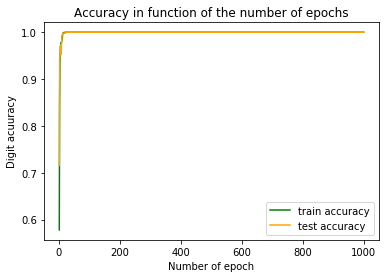

MODEL: BasicCNN with batch normalization, dropout = 0, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 1000, train_error:0.0%, test_error: 2.7%


In [557]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.MultiMarginLoss(), nb_epochs = 1000, momentum = 0.9)

### Unet optimization

#### SGD: momentum = 0.9

[epoch 1] train loss: 1.985, test loss: 1.893
[epoch 2] train loss: 1.485, test loss: 1.346
[epoch 3] train loss: 1.040, test loss: 0.903
[epoch 4] train loss: 0.720, test loss: 0.608
[epoch 5] train loss: 0.512, test loss: 0.412
[epoch 6] train loss: 0.385, test loss: 0.296
[epoch 7] train loss: 0.292, test loss: 0.223
[epoch 8] train loss: 0.226, test loss: 0.171
[epoch 9] train loss: 0.177, test loss: 0.135
[epoch 10] train loss: 0.153, test loss: 0.106


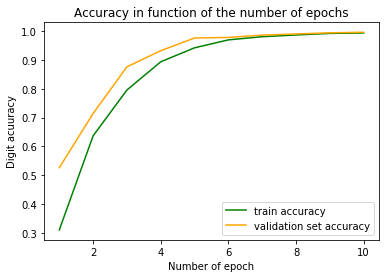

MODEL: UNet, dropout = 0, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 10, train_accuracy:0.996, test_accuracy: 0.968, train_accuracy_digit:0.995, test_accuracy_digit: 0.9535


In [741]:
train_test(UNet(), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 10, momentum = 0.9)

[epoch 1] train loss: 1.966, test loss: 1.933
[epoch 2] train loss: 1.447, test loss: 1.405
[epoch 3] train loss: 1.012, test loss: 0.947
[epoch 4] train loss: 0.720, test loss: 0.637
[epoch 5] train loss: 0.540, test loss: 0.443
[epoch 6] train loss: 0.407, test loss: 0.330
[epoch 7] train loss: 0.339, test loss: 0.281
[epoch 8] train loss: 0.272, test loss: 0.222
[epoch 9] train loss: 0.209, test loss: 0.155
[epoch 10] train loss: 0.174, test loss: 0.137
[epoch 11] train loss: 0.139, test loss: 0.097
[epoch 12] train loss: 0.102, test loss: 0.074
[epoch 13] train loss: 0.084, test loss: 0.065
[epoch 14] train loss: 0.070, test loss: 0.053
[epoch 15] train loss: 0.063, test loss: 0.045
[epoch 16] train loss: 0.059, test loss: 0.041
[epoch 17] train loss: 0.054, test loss: 0.040
[epoch 18] train loss: 0.046, test loss: 0.037
[epoch 19] train loss: 0.041, test loss: 0.033
[epoch 20] train loss: 0.037, test loss: 0.030
[epoch 21] train loss: 0.033, test loss: 0.028
[epoch 22] train loss:

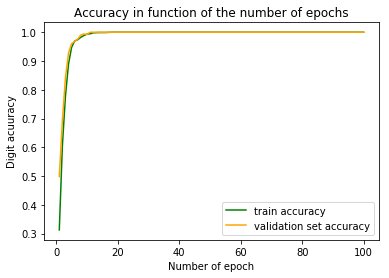

MODEL: UNet, dropout = 0, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_accuracy:1.0, test_accuracy: 0.964, train_accuracy_digit:1.0, test_accuracy_digit: 0.956


In [742]:
train_test(UNet(), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 2.168, test loss: 2.115
[epoch 2] train loss: 1.727, test loss: 1.685
[epoch 3] train loss: 1.288, test loss: 1.241
[epoch 4] train loss: 0.978, test loss: 0.902
[epoch 5] train loss: 0.721, test loss: 0.679
[epoch 6] train loss: 0.580, test loss: 0.539
[epoch 7] train loss: 0.455, test loss: 0.421
[epoch 8] train loss: 0.401, test loss: 0.370
[epoch 9] train loss: 0.368, test loss: 0.322
[epoch 10] train loss: 0.314, test loss: 0.294
[epoch 11] train loss: 0.301, test loss: 0.238
[epoch 12] train loss: 0.258, test loss: 0.216
[epoch 13] train loss: 0.260, test loss: 0.182
[epoch 14] train loss: 0.229, test loss: 0.184
[epoch 15] train loss: 0.210, test loss: 0.155
[epoch 16] train loss: 0.184, test loss: 0.142
[epoch 17] train loss: 0.147, test loss: 0.133
[epoch 18] train loss: 0.138, test loss: 0.110
[epoch 19] train loss: 0.141, test loss: 0.112
[epoch 20] train loss: 0.107, test loss: 0.093
[epoch 21] train loss: 0.105, test loss: 0.093
[epoch 22] train loss:

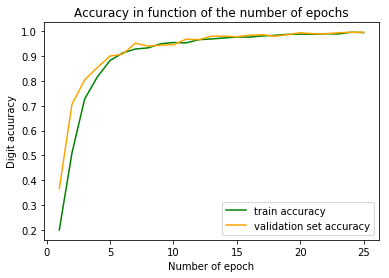

MODEL: UNet, dropout = 0.2, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 25, train_accuracy:0.994, test_accuracy: 0.963, train_accuracy_digit:0.995, test_accuracy_digit: 0.9535


In [743]:
train_test(UNet(dropout = 0.2), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 2.191, test loss: 2.152
[epoch 2] train loss: 1.786, test loss: 1.739
[epoch 3] train loss: 1.314, test loss: 1.253
[epoch 4] train loss: 0.986, test loss: 0.908
[epoch 5] train loss: 0.759, test loss: 0.677
[epoch 6] train loss: 0.620, test loss: 0.530
[epoch 7] train loss: 0.514, test loss: 0.433
[epoch 8] train loss: 0.440, test loss: 0.378
[epoch 9] train loss: 0.389, test loss: 0.322
[epoch 10] train loss: 0.343, test loss: 0.271
[epoch 11] train loss: 0.326, test loss: 0.231
[epoch 12] train loss: 0.297, test loss: 0.213
[epoch 13] train loss: 0.238, test loss: 0.185
[epoch 14] train loss: 0.246, test loss: 0.170
[epoch 15] train loss: 0.214, test loss: 0.157
[epoch 16] train loss: 0.189, test loss: 0.158
[epoch 17] train loss: 0.179, test loss: 0.148
[epoch 18] train loss: 0.181, test loss: 0.129
[epoch 19] train loss: 0.161, test loss: 0.109
[epoch 20] train loss: 0.096, test loss: 0.096
[epoch 21] train loss: 0.095, test loss: 0.099
[epoch 22] train loss:

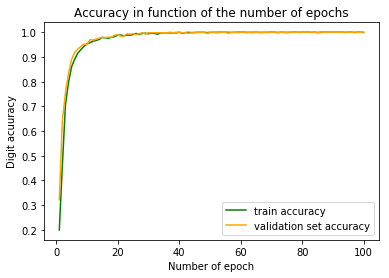

MODEL: UNet, dropout = 0.2, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_accuracy:1.0, test_accuracy: 0.964, train_accuracy_digit:1.0, test_accuracy_digit: 0.9625


In [744]:
train_test(UNet(dropout = 0.2), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 2.271, test loss: 2.252
[epoch 2] train loss: 2.093, test loss: 2.048
[epoch 3] train loss: 1.756, test loss: 1.679
[epoch 4] train loss: 1.408, test loss: 1.317
[epoch 5] train loss: 1.127, test loss: 1.022
[epoch 6] train loss: 0.936, test loss: 0.840
[epoch 7] train loss: 0.773, test loss: 0.698
[epoch 8] train loss: 0.672, test loss: 0.581
[epoch 9] train loss: 0.626, test loss: 0.513
[epoch 10] train loss: 0.570, test loss: 0.438
[epoch 11] train loss: 0.497, test loss: 0.401
[epoch 12] train loss: 0.476, test loss: 0.370
[epoch 13] train loss: 0.408, test loss: 0.332
[epoch 14] train loss: 0.415, test loss: 0.321
[epoch 15] train loss: 0.373, test loss: 0.264
[epoch 16] train loss: 0.346, test loss: 0.260
[epoch 17] train loss: 0.342, test loss: 0.253
[epoch 18] train loss: 0.353, test loss: 0.237
[epoch 19] train loss: 0.337, test loss: 0.235
[epoch 20] train loss: 0.318, test loss: 0.216
[epoch 21] train loss: 0.284, test loss: 0.190
[epoch 22] train loss:

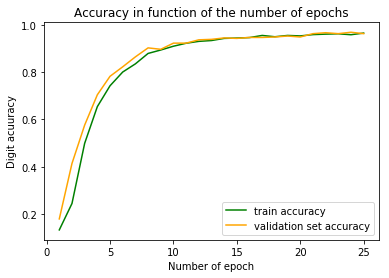

MODEL: UNet, dropout = 0.4, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 25, train_accuracy:0.977, test_accuracy: 0.961, train_accuracy_digit:0.967, test_accuracy_digit: 0.9445


In [745]:
train_test(UNet(dropout = 0.4), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 2.301, test loss: 2.284
[epoch 2] train loss: 2.207, test loss: 2.161
[epoch 3] train loss: 1.930, test loss: 1.877
[epoch 4] train loss: 1.604, test loss: 1.547
[epoch 5] train loss: 1.316, test loss: 1.270
[epoch 6] train loss: 1.120, test loss: 1.051
[epoch 7] train loss: 0.964, test loss: 0.895
[epoch 8] train loss: 0.794, test loss: 0.766
[epoch 9] train loss: 0.693, test loss: 0.659
[epoch 10] train loss: 0.624, test loss: 0.563
[epoch 11] train loss: 0.517, test loss: 0.470
[epoch 12] train loss: 0.489, test loss: 0.430
[epoch 13] train loss: 0.394, test loss: 0.382
[epoch 14] train loss: 0.409, test loss: 0.348
[epoch 15] train loss: 0.413, test loss: 0.308
[epoch 16] train loss: 0.354, test loss: 0.291
[epoch 17] train loss: 0.341, test loss: 0.266
[epoch 18] train loss: 0.308, test loss: 0.251
[epoch 19] train loss: 0.273, test loss: 0.237
[epoch 20] train loss: 0.294, test loss: 0.213
[epoch 21] train loss: 0.235, test loss: 0.206
[epoch 22] train loss:

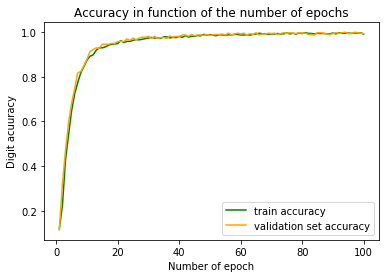

MODEL: UNet, dropout = 0.4, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_accuracy:0.997, test_accuracy: 0.974, train_accuracy_digit:0.9985, test_accuracy_digit: 0.964


In [746]:
train_test(UNet(dropout = 0.4), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

#### Multi Margin loss

#### SGD: momentum = 0.9

[epoch 1] train loss: 0.562, test loss: 0.553
[epoch 2] train loss: 0.274, test loss: 0.240
[epoch 3] train loss: 0.123, test loss: 0.118
[epoch 4] train loss: 0.076, test loss: 0.073
[epoch 5] train loss: 0.053, test loss: 0.049
[epoch 6] train loss: 0.040, test loss: 0.033
[epoch 7] train loss: 0.031, test loss: 0.025
[epoch 8] train loss: 0.025, test loss: 0.022
[epoch 9] train loss: 0.019, test loss: 0.018
[epoch 10] train loss: 0.018, test loss: 0.017
[epoch 11] train loss: 0.015, test loss: 0.012
[epoch 12] train loss: 0.014, test loss: 0.009
[epoch 13] train loss: 0.010, test loss: 0.008
[epoch 14] train loss: 0.010, test loss: 0.006
[epoch 15] train loss: 0.006, test loss: 0.004
[epoch 16] train loss: 0.005, test loss: 0.003
[epoch 17] train loss: 0.003, test loss: 0.002
[epoch 18] train loss: 0.003, test loss: 0.002
[epoch 19] train loss: 0.003, test loss: 0.001
[epoch 20] train loss: 0.003, test loss: 0.001
[epoch 21] train loss: 0.003, test loss: 0.002
[epoch 22] train loss:

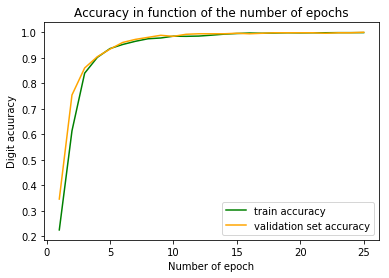

MODEL: UNet, dropout = 0, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 25, train_accuracy:0.999, test_accuracy: 0.969, train_accuracy_digit:0.999, test_accuracy_digit: 0.955


In [747]:
train_test(UNet(), 100, eta = 1e-2, criterion =nn.MultiMarginLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 0.638, test loss: 0.526
[epoch 2] train loss: 0.221, test loss: 0.176
[epoch 3] train loss: 0.098, test loss: 0.076
[epoch 4] train loss: 0.066, test loss: 0.048
[epoch 5] train loss: 0.048, test loss: 0.035
[epoch 6] train loss: 0.038, test loss: 0.026
[epoch 7] train loss: 0.027, test loss: 0.020
[epoch 8] train loss: 0.019, test loss: 0.014
[epoch 9] train loss: 0.014, test loss: 0.011
[epoch 10] train loss: 0.010, test loss: 0.009
[epoch 11] train loss: 0.008, test loss: 0.007
[epoch 12] train loss: 0.007, test loss: 0.005
[epoch 13] train loss: 0.006, test loss: 0.005
[epoch 14] train loss: 0.004, test loss: 0.004
[epoch 15] train loss: 0.003, test loss: 0.003
[epoch 16] train loss: 0.002, test loss: 0.004
[epoch 17] train loss: 0.003, test loss: 0.004
[epoch 18] train loss: 0.002, test loss: 0.003
[epoch 19] train loss: 0.002, test loss: 0.002
[epoch 20] train loss: 0.001, test loss: 0.002
[epoch 21] train loss: 0.001, test loss: 0.001
[epoch 22] train loss:

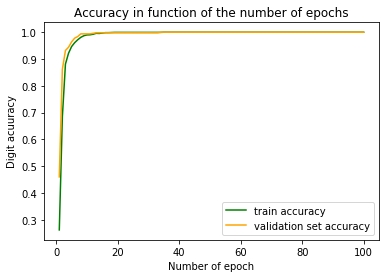

MODEL: UNet, dropout = 0, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 100, train_accuracy:1.0, test_accuracy: 0.969, train_accuracy_digit:1.0, test_accuracy_digit: 0.9565


In [748]:
train_test(UNet(), 100, eta = 1e-2, criterion =nn.MultiMarginLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 0.798, test loss: 0.728
[epoch 2] train loss: 0.441, test loss: 0.398
[epoch 3] train loss: 0.218, test loss: 0.199
[epoch 4] train loss: 0.149, test loss: 0.137
[epoch 5] train loss: 0.126, test loss: 0.111
[epoch 6] train loss: 0.099, test loss: 0.095
[epoch 7] train loss: 0.088, test loss: 0.079
[epoch 8] train loss: 0.073, test loss: 0.070
[epoch 9] train loss: 0.069, test loss: 0.063
[epoch 10] train loss: 0.065, test loss: 0.058
[epoch 11] train loss: 0.048, test loss: 0.055
[epoch 12] train loss: 0.041, test loss: 0.048
[epoch 13] train loss: 0.038, test loss: 0.043
[epoch 14] train loss: 0.041, test loss: 0.042
[epoch 15] train loss: 0.040, test loss: 0.038
[epoch 16] train loss: 0.034, test loss: 0.036
[epoch 17] train loss: 0.032, test loss: 0.029
[epoch 18] train loss: 0.035, test loss: 0.030
[epoch 19] train loss: 0.028, test loss: 0.026
[epoch 20] train loss: 0.029, test loss: 0.025
[epoch 21] train loss: 0.033, test loss: 0.025
[epoch 22] train loss:

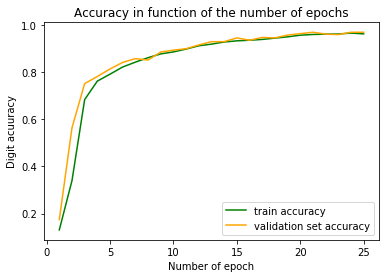

MODEL: UNet, dropout = 0.2, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 25, train_accuracy:0.972, test_accuracy: 0.953, train_accuracy_digit:0.9695, test_accuracy_digit: 0.9405


In [749]:
train_test(UNet(dropout = 0.2), 100, eta = 1e-2, criterion =nn.MultiMarginLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 0.701, test loss: 0.706
[epoch 2] train loss: 0.420, test loss: 0.377
[epoch 3] train loss: 0.225, test loss: 0.183
[epoch 4] train loss: 0.134, test loss: 0.124
[epoch 5] train loss: 0.109, test loss: 0.088
[epoch 6] train loss: 0.093, test loss: 0.075
[epoch 7] train loss: 0.077, test loss: 0.063
[epoch 8] train loss: 0.065, test loss: 0.054
[epoch 9] train loss: 0.057, test loss: 0.048
[epoch 10] train loss: 0.053, test loss: 0.047
[epoch 11] train loss: 0.055, test loss: 0.044
[epoch 12] train loss: 0.045, test loss: 0.037
[epoch 13] train loss: 0.039, test loss: 0.033
[epoch 14] train loss: 0.040, test loss: 0.033
[epoch 15] train loss: 0.036, test loss: 0.033
[epoch 16] train loss: 0.037, test loss: 0.029
[epoch 17] train loss: 0.028, test loss: 0.023
[epoch 18] train loss: 0.036, test loss: 0.024
[epoch 19] train loss: 0.032, test loss: 0.022
[epoch 20] train loss: 0.030, test loss: 0.021
[epoch 21] train loss: 0.030, test loss: 0.020
[epoch 22] train loss:

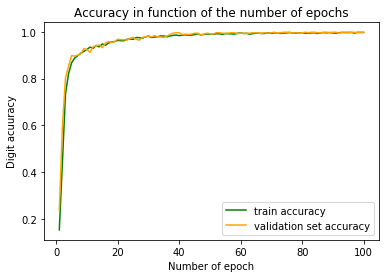

MODEL: UNet, dropout = 0.2, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 100, train_accuracy:0.996, test_accuracy: 0.971, train_accuracy_digit:0.9965, test_accuracy_digit: 0.961


In [750]:
train_test(UNet(dropout = 0.2), 100, eta = 1e-2, criterion =nn.MultiMarginLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 0.863, test loss: 0.824
[epoch 2] train loss: 0.717, test loss: 0.662
[epoch 3] train loss: 0.438, test loss: 0.368
[epoch 4] train loss: 0.241, test loss: 0.210
[epoch 5] train loss: 0.176, test loss: 0.145
[epoch 6] train loss: 0.137, test loss: 0.120
[epoch 7] train loss: 0.126, test loss: 0.100
[epoch 8] train loss: 0.114, test loss: 0.090
[epoch 9] train loss: 0.106, test loss: 0.079
[epoch 10] train loss: 0.101, test loss: 0.069
[epoch 11] train loss: 0.081, test loss: 0.067
[epoch 12] train loss: 0.063, test loss: 0.062
[epoch 13] train loss: 0.065, test loss: 0.057
[epoch 14] train loss: 0.052, test loss: 0.052
[epoch 15] train loss: 0.053, test loss: 0.051
[epoch 16] train loss: 0.063, test loss: 0.048
[epoch 17] train loss: 0.057, test loss: 0.045
[epoch 18] train loss: 0.055, test loss: 0.045
[epoch 19] train loss: 0.053, test loss: 0.045
[epoch 20] train loss: 0.060, test loss: 0.038
[epoch 21] train loss: 0.048, test loss: 0.041
[epoch 22] train loss:

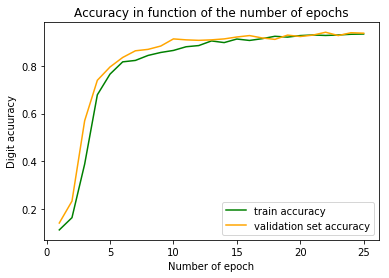

MODEL: UNet, dropout = 0.4, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 25, train_accuracy:0.951, test_accuracy: 0.952, train_accuracy_digit:0.9375, test_accuracy_digit: 0.9305


In [751]:
train_test(UNet(dropout = 0.4), 100, eta = 1e-2, criterion =nn.MultiMarginLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 0.781, test loss: 0.809
[epoch 2] train loss: 0.579, test loss: 0.569
[epoch 3] train loss: 0.302, test loss: 0.287
[epoch 4] train loss: 0.200, test loss: 0.194
[epoch 5] train loss: 0.170, test loss: 0.149
[epoch 6] train loss: 0.143, test loss: 0.129
[epoch 7] train loss: 0.130, test loss: 0.111
[epoch 8] train loss: 0.115, test loss: 0.100
[epoch 9] train loss: 0.092, test loss: 0.093
[epoch 10] train loss: 0.092, test loss: 0.082
[epoch 11] train loss: 0.077, test loss: 0.081
[epoch 12] train loss: 0.076, test loss: 0.067
[epoch 13] train loss: 0.069, test loss: 0.065
[epoch 14] train loss: 0.071, test loss: 0.064
[epoch 15] train loss: 0.070, test loss: 0.055
[epoch 16] train loss: 0.056, test loss: 0.053
[epoch 17] train loss: 0.060, test loss: 0.053
[epoch 18] train loss: 0.056, test loss: 0.049
[epoch 19] train loss: 0.055, test loss: 0.050
[epoch 20] train loss: 0.049, test loss: 0.045
[epoch 21] train loss: 0.047, test loss: 0.043
[epoch 22] train loss:

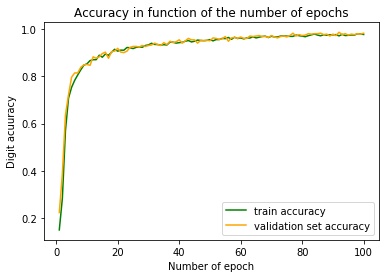

MODEL: UNet, dropout = 0.4, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 100, train_accuracy:0.983, test_accuracy: 0.961, train_accuracy_digit:0.981, test_accuracy_digit: 0.9485


In [752]:
train_test(UNet(dropout = 0.4), 100, eta = 1e-2, criterion =nn.MultiMarginLoss(), nb_epochs = 100, momentum = 0.9)

### UNet2 optimization

#### momentum = 0.9

[epoch 1] train loss: 1.277, test loss: 1.130
[epoch 2] train loss: 0.307, test loss: 0.214
[epoch 3] train loss: 0.179, test loss: 0.096
[epoch 4] train loss: 0.127, test loss: 0.049
[epoch 5] train loss: 0.055, test loss: 0.063
[epoch 6] train loss: 0.048, test loss: 0.037
[epoch 7] train loss: 0.006, test loss: 0.015
[epoch 8] train loss: 0.021, test loss: 0.017
[epoch 9] train loss: 0.006, test loss: 0.005
[epoch 10] train loss: 0.009, test loss: 0.026
[epoch 11] train loss: 0.007, test loss: 0.011
[epoch 12] train loss: 0.002, test loss: 0.002
[epoch 13] train loss: 0.002, test loss: 0.001
[epoch 14] train loss: 0.001, test loss: 0.001
[epoch 15] train loss: 0.001, test loss: 0.001
[epoch 16] train loss: 0.001, test loss: 0.001
[epoch 17] train loss: 0.001, test loss: 0.001
[epoch 18] train loss: 0.001, test loss: 0.001
[epoch 19] train loss: 0.001, test loss: 0.001
[epoch 20] train loss: 0.001, test loss: 0.001
[epoch 21] train loss: 0.001, test loss: 0.000
[epoch 22] train loss:

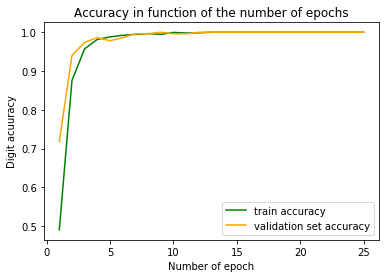

MODEL: UNet2, dropout = 0, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 25, train_accuracy:1.0, test_accuracy: 0.986, train_accuracy_digit:1.0, test_accuracy_digit: 0.978


In [769]:
train_test(UNet2(), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 1.303, test loss: 1.040
[epoch 2] train loss: 0.280, test loss: 0.204
[epoch 3] train loss: 0.150, test loss: 0.116
[epoch 4] train loss: 0.091, test loss: 0.096
[epoch 5] train loss: 0.068, test loss: 0.045
[epoch 6] train loss: 0.160, test loss: 0.079
[epoch 7] train loss: 0.011, test loss: 0.026
[epoch 8] train loss: 0.005, test loss: 0.004
[epoch 9] train loss: 0.009, test loss: 0.018
[epoch 10] train loss: 0.007, test loss: 0.005
[epoch 11] train loss: 0.003, test loss: 0.001
[epoch 12] train loss: 0.001, test loss: 0.001
[epoch 13] train loss: 0.001, test loss: 0.001
[epoch 14] train loss: 0.001, test loss: 0.001
[epoch 15] train loss: 0.001, test loss: 0.001
[epoch 16] train loss: 0.001, test loss: 0.001
[epoch 17] train loss: 0.001, test loss: 0.001
[epoch 18] train loss: 0.001, test loss: 0.001
[epoch 19] train loss: 0.001, test loss: 0.001
[epoch 20] train loss: 0.001, test loss: 0.001
[epoch 21] train loss: 0.001, test loss: 0.000
[epoch 22] train loss:

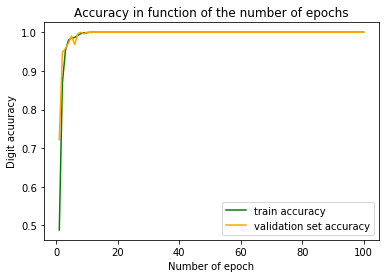

MODEL: UNet2, dropout = 0, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_accuracy:1.0, test_accuracy: 0.983, train_accuracy_digit:1.0, test_accuracy_digit: 0.975


In [758]:
train_test(UNet2(), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 1.892, test loss: 1.898
[epoch 2] train loss: 0.927, test loss: 0.803
[epoch 3] train loss: 0.363, test loss: 0.318
[epoch 4] train loss: 0.211, test loss: 0.146
[epoch 5] train loss: 0.189, test loss: 0.127
[epoch 6] train loss: 0.197, test loss: 0.105
[epoch 7] train loss: 0.104, test loss: 0.078
[epoch 8] train loss: 0.104, test loss: 0.042
[epoch 9] train loss: 0.060, test loss: 0.039
[epoch 10] train loss: 0.045, test loss: 0.030
[epoch 11] train loss: 0.031, test loss: 0.031
[epoch 12] train loss: 0.032, test loss: 0.020
[epoch 13] train loss: 0.037, test loss: 0.018
[epoch 14] train loss: 0.032, test loss: 0.024
[epoch 15] train loss: 0.026, test loss: 0.022
[epoch 16] train loss: 0.016, test loss: 0.010
[epoch 17] train loss: 0.018, test loss: 0.008
[epoch 18] train loss: 0.012, test loss: 0.010
[epoch 19] train loss: 0.007, test loss: 0.004
[epoch 20] train loss: 0.014, test loss: 0.008
[epoch 21] train loss: 0.005, test loss: 0.007
[epoch 22] train loss:

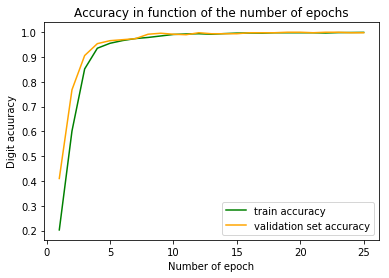

MODEL: UNet2, dropout = 0.2, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 25, train_accuracy:0.998, test_accuracy: 0.979, train_accuracy_digit:0.9985, test_accuracy_digit: 0.974


In [759]:
train_test(UNet2(dropout = 0.2), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 2.041, test loss: 1.986
[epoch 2] train loss: 1.192, test loss: 0.993
[epoch 3] train loss: 0.478, test loss: 0.312
[epoch 4] train loss: 0.247, test loss: 0.171
[epoch 5] train loss: 0.248, test loss: 0.122
[epoch 6] train loss: 0.147, test loss: 0.097
[epoch 7] train loss: 0.150, test loss: 0.140
[epoch 8] train loss: 0.128, test loss: 0.115
[epoch 9] train loss: 0.057, test loss: 0.044
[epoch 10] train loss: 0.047, test loss: 0.045
[epoch 11] train loss: 0.049, test loss: 0.038
[epoch 12] train loss: 0.036, test loss: 0.025
[epoch 13] train loss: 0.021, test loss: 0.021
[epoch 14] train loss: 0.022, test loss: 0.018
[epoch 15] train loss: 0.011, test loss: 0.012
[epoch 16] train loss: 0.015, test loss: 0.009
[epoch 17] train loss: 0.026, test loss: 0.008
[epoch 18] train loss: 0.010, test loss: 0.006
[epoch 19] train loss: 0.015, test loss: 0.011
[epoch 20] train loss: 0.029, test loss: 0.008
[epoch 21] train loss: 0.027, test loss: 0.015
[epoch 22] train loss:

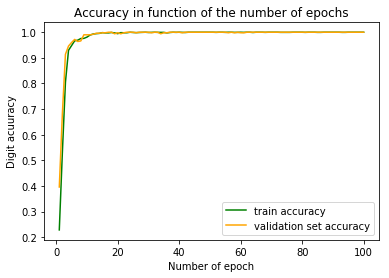

MODEL: UNet2, dropout = 0.2, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_accuracy:1.0, test_accuracy: 0.973, train_accuracy_digit:1.0, test_accuracy_digit: 0.972


In [760]:
train_test(UNet2(dropout = 0.2), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 2.245, test loss: 2.233
[epoch 2] train loss: 1.905, test loss: 1.897
[epoch 3] train loss: 1.334, test loss: 1.267
[epoch 4] train loss: 0.730, test loss: 0.608
[epoch 5] train loss: 0.479, test loss: 0.337
[epoch 6] train loss: 0.274, test loss: 0.243
[epoch 7] train loss: 0.298, test loss: 0.184
[epoch 8] train loss: 0.378, test loss: 0.194
[epoch 9] train loss: 0.268, test loss: 0.159
[epoch 10] train loss: 0.171, test loss: 0.114
[epoch 11] train loss: 0.167, test loss: 0.093
[epoch 12] train loss: 0.182, test loss: 0.070
[epoch 13] train loss: 0.109, test loss: 0.084
[epoch 14] train loss: 0.100, test loss: 0.085
[epoch 15] train loss: 0.068, test loss: 0.040
[epoch 16] train loss: 0.077, test loss: 0.053
[epoch 17] train loss: 0.109, test loss: 0.061
[epoch 18] train loss: 0.061, test loss: 0.044
[epoch 19] train loss: 0.111, test loss: 0.036
[epoch 20] train loss: 0.077, test loss: 0.034
[epoch 21] train loss: 0.066, test loss: 0.039
[epoch 22] train loss:

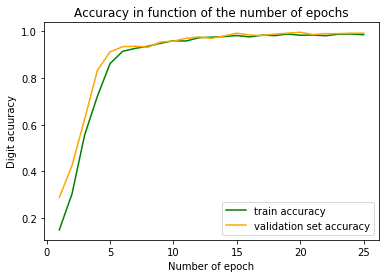

MODEL: UNet2, dropout = 0.4, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 25, train_accuracy:0.996, test_accuracy: 0.973, train_accuracy_digit:0.9885, test_accuracy_digit: 0.9635


In [761]:
train_test(UNet2(dropout = 0.4), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 2.270, test loss: 2.243
[epoch 2] train loss: 1.969, test loss: 1.884
[epoch 3] train loss: 1.197, test loss: 1.060
[epoch 4] train loss: 0.624, test loss: 0.527
[epoch 5] train loss: 0.329, test loss: 0.294
[epoch 6] train loss: 0.278, test loss: 0.204
[epoch 7] train loss: 0.333, test loss: 0.174
[epoch 8] train loss: 0.312, test loss: 0.150
[epoch 9] train loss: 0.219, test loss: 0.141
[epoch 10] train loss: 0.199, test loss: 0.133
[epoch 11] train loss: 0.156, test loss: 0.125
[epoch 12] train loss: 0.105, test loss: 0.078
[epoch 13] train loss: 0.178, test loss: 0.069
[epoch 14] train loss: 0.104, test loss: 0.056
[epoch 15] train loss: 0.109, test loss: 0.029
[epoch 16] train loss: 0.101, test loss: 0.073
[epoch 17] train loss: 0.090, test loss: 0.042
[epoch 18] train loss: 0.074, test loss: 0.036
[epoch 19] train loss: 0.041, test loss: 0.044
[epoch 20] train loss: 0.084, test loss: 0.040
[epoch 21] train loss: 0.049, test loss: 0.039
[epoch 22] train loss:

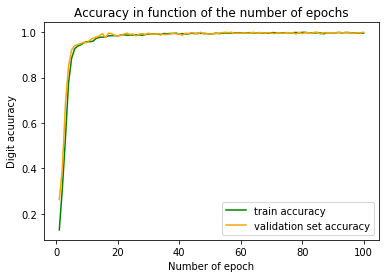

MODEL: UNet2, dropout = 0.4, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_accuracy:0.996, test_accuracy: 0.976, train_accuracy_digit:0.997, test_accuracy_digit: 0.968


In [762]:
train_test(UNet2(dropout = 0.4), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

#### Multi Margin loss

#### SGD: momentum = 0.9

[epoch 1] train loss: 0.212, test loss: 0.153
[epoch 2] train loss: 0.064, test loss: 0.036
[epoch 3] train loss: 0.043, test loss: 0.016
[epoch 4] train loss: 0.024, test loss: 0.010
[epoch 5] train loss: 0.013, test loss: 0.007
[epoch 6] train loss: 0.005, test loss: 0.005
[epoch 7] train loss: 0.002, test loss: 0.004
[epoch 8] train loss: 0.002, test loss: 0.003
[epoch 9] train loss: 0.001, test loss: 0.002
[epoch 10] train loss: 0.000, test loss: 0.002
[epoch 11] train loss: 0.000, test loss: 0.001
[epoch 12] train loss: 0.000, test loss: 0.001
[epoch 13] train loss: 0.000, test loss: 0.001
[epoch 14] train loss: 0.000, test loss: 0.001
[epoch 15] train loss: 0.000, test loss: 0.001
[epoch 16] train loss: 0.000, test loss: 0.001
[epoch 17] train loss: 0.000, test loss: 0.000
[epoch 18] train loss: 0.000, test loss: 0.000
[epoch 19] train loss: 0.000, test loss: 0.000
[epoch 20] train loss: 0.000, test loss: 0.000
[epoch 21] train loss: 0.000, test loss: 0.000
[epoch 22] train loss:

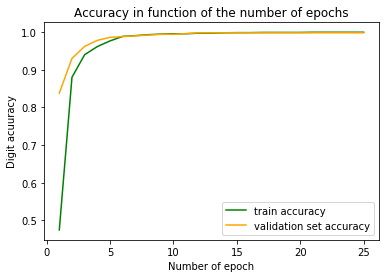

MODEL: UNet2, dropout = 0, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 25, train_accuracy:0.999, test_accuracy: 0.976, train_accuracy_digit:0.9995, test_accuracy_digit: 0.9645


In [763]:
train_test(UNet2(), 100, eta = 1e-2, criterion =nn.MultiMarginLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 0.226, test loss: 0.155
[epoch 2] train loss: 0.058, test loss: 0.035
[epoch 3] train loss: 0.034, test loss: 0.016
[epoch 4] train loss: 0.022, test loss: 0.010
[epoch 5] train loss: 0.015, test loss: 0.006
[epoch 6] train loss: 0.009, test loss: 0.005
[epoch 7] train loss: 0.006, test loss: 0.003
[epoch 8] train loss: 0.005, test loss: 0.002
[epoch 9] train loss: 0.003, test loss: 0.002
[epoch 10] train loss: 0.002, test loss: 0.001
[epoch 11] train loss: 0.001, test loss: 0.001
[epoch 12] train loss: 0.001, test loss: 0.001
[epoch 13] train loss: 0.001, test loss: 0.001
[epoch 14] train loss: 0.000, test loss: 0.001
[epoch 15] train loss: 0.000, test loss: 0.000
[epoch 16] train loss: 0.000, test loss: 0.000
[epoch 17] train loss: 0.000, test loss: 0.000
[epoch 18] train loss: 0.000, test loss: 0.000
[epoch 19] train loss: 0.000, test loss: 0.000
[epoch 20] train loss: 0.000, test loss: 0.000
[epoch 21] train loss: 0.000, test loss: 0.000
[epoch 22] train loss:

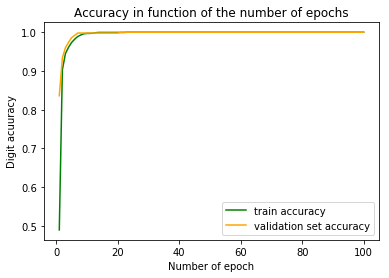

MODEL: UNet2, dropout = 0, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 100, train_accuracy:1.0, test_accuracy: 0.97, train_accuracy_digit:1.0, test_accuracy_digit: 0.9615


In [764]:
train_test(UNet2(), 100, eta = 1e-2, criterion =nn.MultiMarginLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 0.619, test loss: 0.572
[epoch 2] train loss: 0.182, test loss: 0.125
[epoch 3] train loss: 0.088, test loss: 0.055
[epoch 4] train loss: 0.061, test loss: 0.036
[epoch 5] train loss: 0.064, test loss: 0.030
[epoch 6] train loss: 0.043, test loss: 0.024
[epoch 7] train loss: 0.050, test loss: 0.020
[epoch 8] train loss: 0.041, test loss: 0.019
[epoch 9] train loss: 0.034, test loss: 0.017
[epoch 10] train loss: 0.028, test loss: 0.014
[epoch 11] train loss: 0.030, test loss: 0.014
[epoch 12] train loss: 0.020, test loss: 0.012
[epoch 13] train loss: 0.016, test loss: 0.010
[epoch 14] train loss: 0.021, test loss: 0.010
[epoch 15] train loss: 0.012, test loss: 0.008
[epoch 16] train loss: 0.017, test loss: 0.009
[epoch 17] train loss: 0.009, test loss: 0.008
[epoch 18] train loss: 0.013, test loss: 0.008
[epoch 19] train loss: 0.014, test loss: 0.008
[epoch 20] train loss: 0.011, test loss: 0.006
[epoch 21] train loss: 0.011, test loss: 0.005
[epoch 22] train loss:

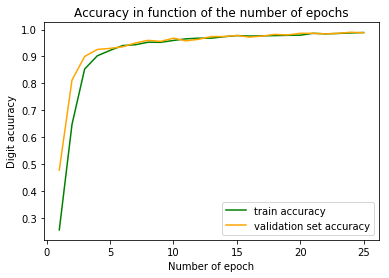

MODEL: UNet2, dropout = 0.2, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 25, train_accuracy:0.992, test_accuracy: 0.969, train_accuracy_digit:0.9905, test_accuracy_digit: 0.959


In [765]:
train_test(UNet2(dropout = 0.2), 100, eta = 1e-2, criterion =nn.MultiMarginLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 0.631, test loss: 0.572
[epoch 2] train loss: 0.142, test loss: 0.107
[epoch 3] train loss: 0.084, test loss: 0.057
[epoch 4] train loss: 0.057, test loss: 0.037
[epoch 5] train loss: 0.055, test loss: 0.029
[epoch 6] train loss: 0.038, test loss: 0.028
[epoch 7] train loss: 0.029, test loss: 0.019
[epoch 8] train loss: 0.026, test loss: 0.015
[epoch 9] train loss: 0.027, test loss: 0.014
[epoch 10] train loss: 0.021, test loss: 0.011
[epoch 11] train loss: 0.021, test loss: 0.011
[epoch 12] train loss: 0.016, test loss: 0.010
[epoch 13] train loss: 0.014, test loss: 0.011
[epoch 14] train loss: 0.015, test loss: 0.009
[epoch 15] train loss: 0.017, test loss: 0.008
[epoch 16] train loss: 0.015, test loss: 0.007
[epoch 17] train loss: 0.009, test loss: 0.005
[epoch 18] train loss: 0.014, test loss: 0.007
[epoch 19] train loss: 0.007, test loss: 0.005
[epoch 20] train loss: 0.010, test loss: 0.006
[epoch 21] train loss: 0.010, test loss: 0.005
[epoch 22] train loss:

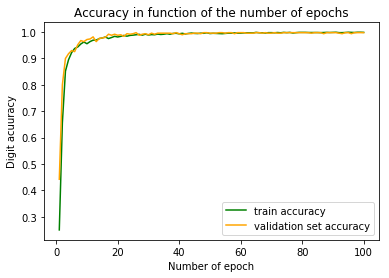

MODEL: UNet2, dropout = 0.2, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 100, train_accuracy:0.999, test_accuracy: 0.976, train_accuracy_digit:0.9995, test_accuracy_digit: 0.969


In [766]:
train_test(UNet2(dropout = 0.2), 100, eta = 1e-2, criterion =nn.MultiMarginLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 0.867, test loss: 0.849
[epoch 2] train loss: 0.624, test loss: 0.598
[epoch 3] train loss: 0.230, test loss: 0.185
[epoch 4] train loss: 0.109, test loss: 0.084
[epoch 5] train loss: 0.083, test loss: 0.060
[epoch 6] train loss: 0.056, test loss: 0.050
[epoch 7] train loss: 0.061, test loss: 0.040
[epoch 8] train loss: 0.045, test loss: 0.036
[epoch 9] train loss: 0.044, test loss: 0.036
[epoch 10] train loss: 0.058, test loss: 0.031
[epoch 11] train loss: 0.040, test loss: 0.026
[epoch 12] train loss: 0.031, test loss: 0.025
[epoch 13] train loss: 0.036, test loss: 0.023
[epoch 14] train loss: 0.054, test loss: 0.025
[epoch 15] train loss: 0.031, test loss: 0.020
[epoch 16] train loss: 0.023, test loss: 0.018
[epoch 17] train loss: 0.033, test loss: 0.016
[epoch 18] train loss: 0.029, test loss: 0.017
[epoch 19] train loss: 0.035, test loss: 0.014
[epoch 20] train loss: 0.028, test loss: 0.017
[epoch 21] train loss: 0.021, test loss: 0.014
[epoch 22] train loss:

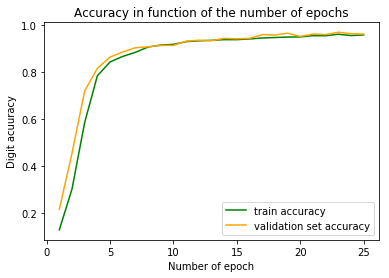

MODEL: UNet2, dropout = 0.4, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 25, train_accuracy:0.982, test_accuracy: 0.961, train_accuracy_digit:0.964, test_accuracy_digit: 0.946


In [767]:
train_test(UNet2(dropout = 0.4), 100, eta = 1e-2, criterion =nn.MultiMarginLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 0.857, test loss: 0.828
[epoch 2] train loss: 0.618, test loss: 0.542
[epoch 3] train loss: 0.237, test loss: 0.177
[epoch 4] train loss: 0.114, test loss: 0.092
[epoch 5] train loss: 0.080, test loss: 0.063
[epoch 6] train loss: 0.062, test loss: 0.049
[epoch 7] train loss: 0.057, test loss: 0.044
[epoch 8] train loss: 0.055, test loss: 0.034
[epoch 9] train loss: 0.059, test loss: 0.034
[epoch 10] train loss: 0.045, test loss: 0.029
[epoch 11] train loss: 0.044, test loss: 0.030
[epoch 12] train loss: 0.037, test loss: 0.024
[epoch 13] train loss: 0.043, test loss: 0.021
[epoch 14] train loss: 0.024, test loss: 0.021
[epoch 15] train loss: 0.038, test loss: 0.021
[epoch 16] train loss: 0.026, test loss: 0.020
[epoch 17] train loss: 0.030, test loss: 0.016
[epoch 18] train loss: 0.023, test loss: 0.018
[epoch 19] train loss: 0.021, test loss: 0.014
[epoch 20] train loss: 0.024, test loss: 0.015
[epoch 21] train loss: 0.024, test loss: 0.013
[epoch 22] train loss:

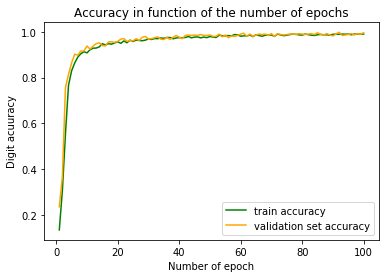

MODEL: UNet2, dropout = 0.4, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 100, train_accuracy:0.988, test_accuracy: 0.97, train_accuracy_digit:0.9905, test_accuracy_digit: 0.966


In [768]:
train_test(UNet2(dropout = 0.4), 100, eta = 1e-2, criterion =nn.MultiMarginLoss(), nb_epochs = 100, momentum = 0.9)